# Introduction

*spotter* is a package to compute approximate forward models of fluxes and spectra time-series of non-uniform stars. 

Its main advantage over other frameworks is its capability to model small scale features thanks to the surface being subdivided into equal-area pixels. In order to do that, *spotter* exploits the  [HEALPix](https://healpix.jpl.nasa.gov/) subdivision scheme (through the python package [*healpy*](https://healpy.readthedocs.io/en/latest/)).

## HEALPix maps
Using healpy, a stellar surface simply consists in an array of values, one for each pixel. Let's create a random healpix map and show it.


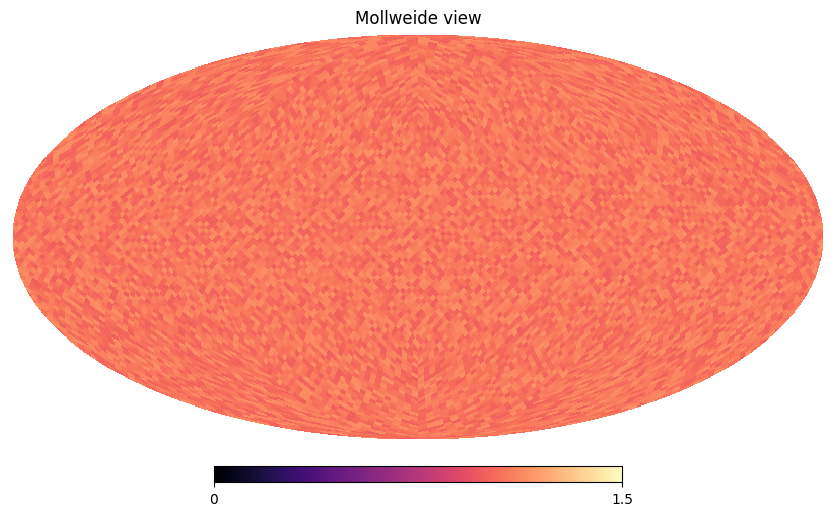

In [1]:
import healpy as hp
import numpy as np
import matplotlib.pyplot as plt

N = 2**5  # healpix map sides
n = hp.nside2npix(N)  # number of pixels
x = 1 + np.random.rand(n) * 0.15  # the map

hp.mollview(x, min=0, max=1.5, cmap="magma")

## *spotter* maps

*spotter* use these *all-sky* maps to represent the surface of stars and implements the functions to compute the integrated flux of the stellar disk at a given phase. For example

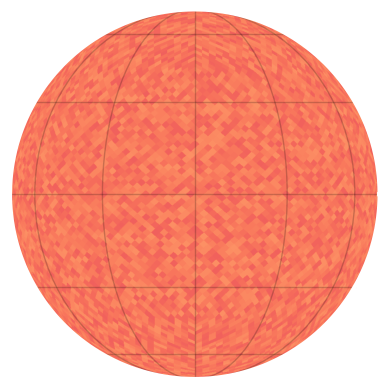

In [2]:
from spotter.experimental import show

show(x, vmin=0.0, vmax=1.5)

and adding some polynomial limb darkening

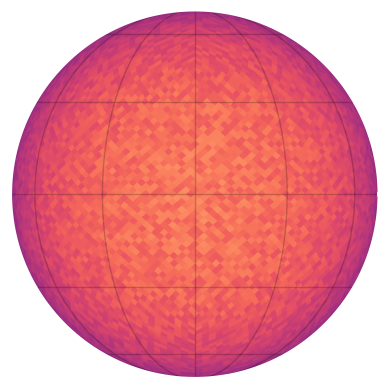

In [3]:
u = (0.3, 0.2)
show(x, u=u, vmin=0.0, vmax=1.5)

## Spots and faculae

We can now add a spot to this map

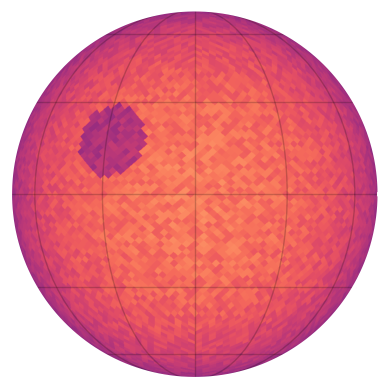

In [4]:
from spotter.experimental.core import spots

x_spotted = x - spots(x, 0.3, 0.5, 0.2) * 0.3

show(x_spotted, u=u, vmin=0.0, vmax=1.5)

and some faculae

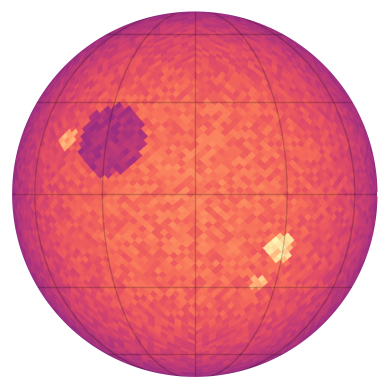

In [5]:
faculae = np.sum(
    [
        spots(x, 0.3, 0.8, 0.06) * 0.3 * x,
        spots(x, -0.3, -0.5, 0.08) * 0.35 * x,
        spots(x, -0.5, -0.4, 0.04) * 0.3 * x,
    ],
    0,
)

x_active = x_spotted + faculae

show(x_active, u=u, vmin=0.0, vmax=1.5)

## Light curves

We can also compute the light curve of this map

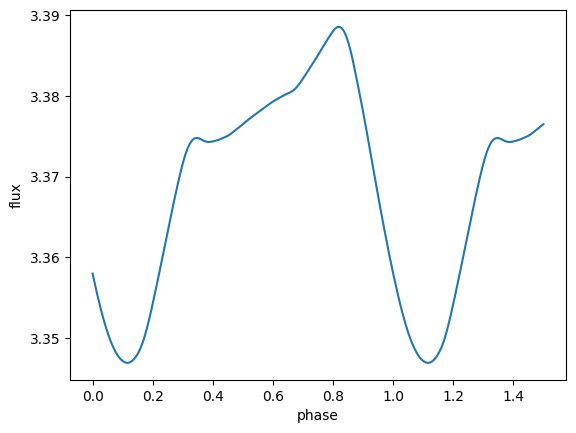

In [6]:
import jax
from spotter.experimental.core import flux

phase = np.linspace(0, 3 * np.pi, 200)
flux = jax.vmap(flux, in_axes=(None, None, None, 0))(x_active, 0.0, u, phase)

plt.plot(phase / (2 * np.pi), flux)
plt.xlabel("phase")
_ = plt.ylabel("flux")

```{note}
All functions in *spotter* are carefully implemented with `jax`, meaning that they can be vectorized and run on GPUs. For example this could be useful to evaluate the flux of a very large number of maps.
```

## jax

Using `jax`, other observables can be obtained in no time. For example

In [7]:
from spotter import distributions
from spotter.experimental.core import amplitude

# generate maps with a single random spot
n_spots = 500
latlon = distributions.uniform(n_spots)
radii = np.random.uniform(0.01, 0.9, n_spots)
contrast = np.random.uniform(0.01, 0.9, n_spots)
xs = 1 - jax.vmap(jax.jit(spots, static_argnums=(0,)), in_axes=(None, 0, 0, 0))(
    N, *latlon, radii
)

amplitude = jax.jit(amplitude(N, 0.0, u))
values = amplitude(xs)

Here we evaluated the amplitude of the rotational light curves of 500 maps, each containing a single random spot. Let's estimate the processing time of this computation

In [8]:
%timeit amplitude(xs)

18 ms ± 1.73 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


i.e. about tens of $\mu s$ per unique map!

## Transiting exoplanets

Other features of *spotter* are useful to compute the spot coverage, either of the map itself

In [9]:
# trivial
spotted = x_spotted < 1.0
coverage = np.mean(spotted)

print(f"coverage: {coverage * 100:.2f}%")

coverage: 1.00%


or within a specific transit chord

chord coverage: 17.38%


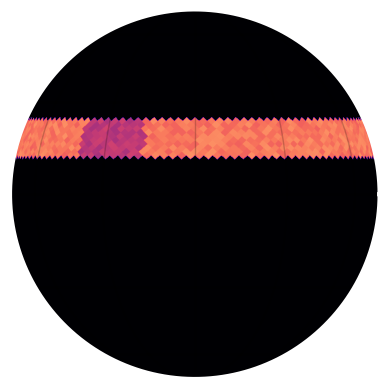

In [10]:
from spotter.experimental.core import mask_projected_limb, transit_chord, vec

transit = transit_chord(N, 0.1, b=0.3)

mask, area, _ = mask_projected_limb(vec(N), 0.0, 0.0, u)

spotted = (x_spotted < 1.0) * mask
transited = transit * mask > 0.0

# let's show the chord
show(x_spotted * transited, vmin=0.0, vmax=1.5)

# covering fraction in the chord
chord_coverage = (spotted * transited * area).sum() / (transited * area).sum()
print(f"chord coverage: {chord_coverage * 100:.2f}%")

which is useful to compute transmission spectroscopy stellar contamination effects (the real motive of the *spotter* development).